# Overfitting and underfitting


**Credits to: Code and text adapted from [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) Chapter 3, Section 6**


**The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of 
adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" 
refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of 
course, but you do not control generalization; you can only adjust the model based on its training data**.

**At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on 
test data. While this is happening, your model is said to be _under-fit_: there is still progress to be made; the network hasn't yet 
modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops 
improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns 
that are specific to the training data but that are misleading or irrelevant when it comes to new data**.

To prevent a model from learning misleading or irrelevant patterns found in the training data, **_the best solution is of course to get 
more training data_**. A model trained on more data will naturally generalize better. When that is no longer possible, **the next best solution 
is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to 
store**. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most 
**prominent** patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called **_regularization_**. Let's review some of the most common regularization 
techniques, and let's apply them in practice to improve our movie classification model from  the previous chapter.

## Set up:

Dependencies:

In [ ]:
! pip install torchinfo

In [ ]:
import numpy as np
import keras
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from keras.datasets import imdb
from torch.utils.data import Dataset, DataLoader
from pprint import pprint
from torchinfo import summary

ModuleNotFoundError: ignored

Seed:

In [ ]:
seed = 7777
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Device:

In [ ]:
# set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

Note: in this notebook we will be using the IMDB test set as our validation set. It doesn't matter in this context.

### Download dataset

In [ ]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print(decoded_review)

1654784/1641221 [==============================] - 0s 0us/step
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amaz

In [ ]:
# One-hot encoding of document. Each number indicate a word presents (1) or does not present in the doc (0)
print(train_data[0][:5])
print(x_train[0][:50])  # dictionary

[1, 14, 22, 16, 43]
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0.]


Define dataset class:

In [ ]:
class IMDB_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.size()[0]

# dataset
train_data = IMDB_dataset(x_train, y_train)
test_data = IMDB_dataset(x_test, y_test)

# Fighting overfitting

## Reducing the network's size


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is 
determined by the number of layers and the number of units per layer). In deep learning, **the number of learnable parameters in a model is 
often referred to as the model's "capacity"**. Intuitively, **a model with more parameters will have more "memorization capacity"** and therefore 
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any 
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the 
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying 
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge 
is generalization, not fitting.

On the other hand, if the network has **limited memorization resources**, it will not be able to learn this mapping as easily, and thus, in 
order to minimize its loss, it will have to resort to learning **compressed representations that have predictive power** regarding the targets -- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using **models that have 
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources**. There is a compromise to be 
found between **"too much capacity"** and **"not enough capacity"**.

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You 
will have to evaluate an array of different architectures (**on your validation set, not on your test set**, of course) in order to find the 
right model size for your data. The general workflow to find an appropriate model size is to **start with relatively few layers and 
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the 
validation loss**.

Let's try this on our movie review classification network.

Define model class

In [ ]:
# simple_model
class simple_model(nn.Module):
    def __init__(self, hidden_units):
        # initialize parent class
        super(simple_model, self).__init__()
        # define layers
        self.classifier = nn.Sequential(  # define a subcomponent of neural network or another to define model
            nn.Linear(in_features=10000, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=1)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [ ]:
model_visual = simple_model(16)
summary(model_visual, (10, 10_000))

Layer (type:depth-idx)                   Output Shape              Param #
simple_model                             --                        --
├─Sequential: 1-1                        [10, 1]                   --
│    └─Linear: 2-1                       [10, 16]                  160,016
│    └─ReLU: 2-2                         [10, 16]                  --
│    └─Linear: 2-3                       [10, 16]                  272
│    └─ReLU: 2-4                         [10, 16]                  --
│    └─Linear: 2-5                       [10, 1]                   17
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
Total mult-adds (M): 1.60
Input size (MB): 0.40
Forward/backward pass size (MB): 0.00
Params size (MB): 0.64
Estimated Total Size (MB): 1.04

Train model function:

In [ ]:
def train_model(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1) # (num_batch, 1) -> (num_batch,)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train_acc:{train_acc:.5f}, valid loss:{val_loss:.5f} valid acc:{val_acc:.5f}")
    
    return history

**BCEWithLogistsLoss()**:  
This loss function is just a combination of sigmoid layer and binary cross entropy layer. The combination enable the function to achieve a higher numerical stability(See: [this](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/)). When we use it, we don't need to add a sigmoid layer in our model.

A short example:

In [ ]:
exapmle = torch.full([5,2], 2.5)
print(exapmle)
print(exapmle.view(-1))

tensor([[2.5000, 2.5000],
        [2.5000, 2.5000],
        [2.5000, 2.5000],
        [2.5000, 2.5000],
        [2.5000, 2.5000]])
tensor([2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000,
        2.5000])


In [ ]:
type(a)

list

In [ ]:
a = torch.tensor([[2.5000, 3.5000],
        [2.5000, 3.5000],
        [2.5000, 3.5000],
        [2.5000, 3.5000],
        [2.5000, 3.5000]])
a.view(-1)

tensor([2.5000, 3.5000, 2.5000, 3.5000, 2.5000, 3.5000, 2.5000, 3.5000, 2.5000,
        3.5000])

In [ ]:
target = torch.ones([64, 1], dtype=torch.float32) 
output = torch.full([64, 1], 1.5)

print(target[:5])
print(output[:5])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[1.5000],
        [1.5000],
        [1.5000],
        [1.5000],
        [1.5000]])


In [ ]:
# apply
criterion = nn.BCEWithLogitsLoss()  # defeault reduction is mean
print(criterion(output, target))

tensor(0.2014)


It equals to sigmoid layer following Binary Cross Entropy:

In [ ]:
sigmoid_func = nn.Sigmoid()
BCE_func = nn.BCELoss()
print(BCE_func(sigmoid_func(output), target))

tensor(0.2014)


Train model:

In [ ]:
original = simple_model(16)
original_hist = train_model(original, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.57001 train_acc:0.78928, valid loss:0.45044 valid acc:0.86093
Epoch:2 / 20, train loss:0.34843 train_acc:0.88555, valid loss:0.31835 valid acc:0.88211
Epoch:3 / 20, train loss:0.25595 train_acc:0.90529, valid loss:0.28186 valid acc:0.88951
Epoch:4 / 20, train loss:0.21653 train_acc:0.92064, valid loss:0.27219 valid acc:0.89114
Epoch:5 / 20, train loss:0.19204 train_acc:0.93019, valid loss:0.27194 valid acc:0.89122
Epoch:6 / 20, train loss:0.17345 train_acc:0.93758, valid loss:0.27651 valid acc:0.89051
Epoch:7 / 20, train loss:0.15806 train_acc:0.94373, valid loss:0.28424 valid acc:0.88795
Epoch:8 / 20, train loss:0.14472 train_acc:0.94941, valid loss:0.29435 valid acc:0.88523
Epoch:9 / 20, train loss:0.13282 train_acc:0.95460, valid loss:0.30625 valid acc:0.88247
Epoch:10 / 20, train loss:0.12206 train_acc:0.95820, valid loss:0.31986 valid acc:0.87968
Epoch:11 / 20, train loss:0.11220 train_acc:0.96272, valid loss:0.33466 valid acc:0.87780
Epoc

In [ ]:
smaller = simple_model(4)
smaller_hist = train_model(smaller, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.67013 train_acc:0.50771, valid loss:0.62735 valid acc:0.58144
Epoch:2 / 20, train loss:0.55943 train_acc:0.77290, valid loss:0.51089 valid acc:0.84647
Epoch:3 / 20, train loss:0.43994 train_acc:0.87440, valid loss:0.41382 valid acc:0.86929
Epoch:4 / 20, train loss:0.35219 train_acc:0.89094, valid loss:0.35202 valid acc:0.87824
Epoch:5 / 20, train loss:0.29637 train_acc:0.90094, valid loss:0.31626 valid acc:0.88339
Epoch:6 / 20, train loss:0.26081 train_acc:0.90929, valid loss:0.29584 valid acc:0.88699
Epoch:7 / 20, train loss:0.23666 train_acc:0.91644, valid loss:0.28411 valid acc:0.88935
Epoch:8 / 20, train loss:0.21887 train_acc:0.92168, valid loss:0.27743 valid acc:0.89074
Epoch:9 / 20, train loss:0.20485 train_acc:0.92707, valid loss:0.27387 valid acc:0.89134
Epoch:10 / 20, train loss:0.19322 train_acc:0.93123, valid loss:0.27243 valid acc:0.89055
Epoch:11 / 20, train loss:0.18322 train_acc:0.93506, valid loss:0.27249 valid acc:0.89031
Epoc


Here's a comparison of the validation losses of the original network and the smaller network(remember: a lower validation loss signals a better model).

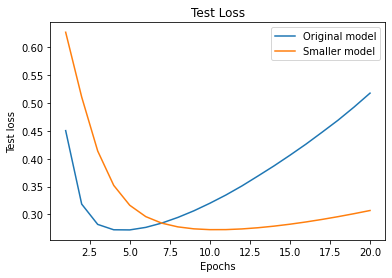

In [ ]:
plt.plot(range(1, 21), original_hist['test_loss'], label='Original model')
plt.plot(range(1, 21), smaller_hist['test_loss'], label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()
plt.title("Test Loss")
plt.show()


As you can see, the smaller network starts overfitting later than the reference one (after 10 epochs rather than 4) and its performance 
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [ ]:
bigger = simple_model(512)
bigger_hist = train_model(bigger, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.31423 train_acc:0.87116, valid loss:0.28231 valid acc:0.88659
Epoch:2 / 20, train loss:0.18789 train_acc:0.92943, valid loss:0.31273 valid acc:0.87644
Epoch:3 / 20, train loss:0.12744 train_acc:0.95524, valid loss:0.36727 valid acc:0.86717
Epoch:4 / 20, train loss:0.06917 train_acc:0.97806, valid loss:0.45023 valid acc:0.86225
Epoch:5 / 20, train loss:0.02631 train_acc:0.99245, valid loss:0.63411 valid acc:0.85722
Epoch:6 / 20, train loss:0.00826 train_acc:0.99688, valid loss:0.86613 valid acc:0.85774
Epoch:7 / 20, train loss:0.00409 train_acc:0.99800, valid loss:0.95088 valid acc:0.85802
Epoch:8 / 20, train loss:0.00277 train_acc:0.99856, valid loss:1.08808 valid acc:0.85486
Epoch:9 / 20, train loss:0.00105 train_acc:0.99884, valid loss:1.23917 valid acc:0.85562
Epoch:10 / 20, train loss:0.00016 train_acc:0.99904, valid loss:1.39801 valid acc:0.85674
Epoch:11 / 20, train loss:0.00087 train_acc:0.99876, valid loss:1.40223 valid acc:0.85506
Epoc

Here's how the bigger network fares compared to the reference one.

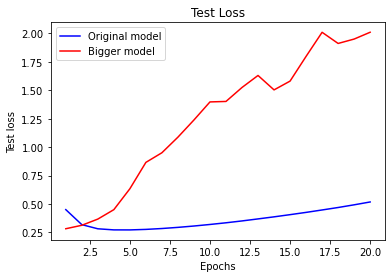

In [ ]:
plt.plot(range(1, 21), original_hist['test_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), bigger_hist['test_loss'], 'r-', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()
plt.title("Test Loss")

plt.show()


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also 
more noisy.

Meanwhile, here are the training losses for our two networks:

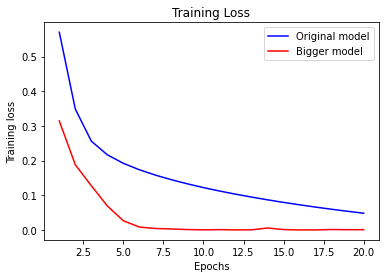

In [ ]:
plt.plot(range(1, 21), original_hist['train_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), bigger_hist['train_loss'], 'r-', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()
plt.title("Training Loss")

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and validation loss).

## Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the 
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some 
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and 
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer 
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity 
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called 
`weight regularization` or `norm regularization`, and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This 
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the 
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called 
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different 
name confuse you: weight decay is mathematically the exact same as L2 regularization.

To apply L2 regularization in Pytorch, we just need a minor modification in train function:

- L2: Use `weight_decay` parameter in optimizer, i.e.,  `torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)`

- L1: There is no torch implementation for L1 analogous to Keras. However, the implementation of L1 is very straightforward, e.g.:




```
# Implementation of L1 Regularizer

loss = loss_fn(outputs, labels) # loss
l1_lambda = 0.001 # L1 coefficient
l1_norm = sum(p.abs().sum() for p in model.parameters())  # add up L1 norma of parameters

loss = loss + l1_lambda * l1_norm  # add to the loss
```



In [ ]:
# define model
l2_model = simple_model(16)

In [ ]:
def train_model_l2(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32, l2=0.01):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2) # weight decay == l2

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train_acc:{train_acc:.5f}, valid loss:{val_loss:.5f} valid acc:{val_acc:.5f}")
    
    return history

Here's the impact of our L2 regularization penalty:

In [ ]:
l2_model_hist = train_model_l2(l2_model, train_data, test_data, device, l2=0.01)

Training Start
Epoch:1 / 20, train loss:0.59035 train_acc:0.78852, valid loss:0.45364 valid acc:0.86221
Epoch:2 / 20, train loss:0.36095 train_acc:0.87792, valid loss:0.32946 valid acc:0.87768
Epoch:3 / 20, train loss:0.28502 train_acc:0.89510, valid loss:0.30129 valid acc:0.88255
Epoch:4 / 20, train loss:0.25587 train_acc:0.90501, valid loss:0.29171 valid acc:0.88399
Epoch:5 / 20, train loss:0.23874 train_acc:0.91176, valid loss:0.28773 valid acc:0.88387
Epoch:6 / 20, train loss:0.22663 train_acc:0.91768, valid loss:0.28604 valid acc:0.88415
Epoch:7 / 20, train loss:0.21726 train_acc:0.92219, valid loss:0.28552 valid acc:0.88375
Epoch:8 / 20, train loss:0.20960 train_acc:0.92551, valid loss:0.28566 valid acc:0.88275
Epoch:9 / 20, train loss:0.20312 train_acc:0.92863, valid loss:0.28620 valid acc:0.88215
Epoch:10 / 20, train loss:0.19753 train_acc:0.93103, valid loss:0.28702 valid acc:0.88171
Epoch:11 / 20, train loss:0.19263 train_acc:0.93290, valid loss:0.28801 valid acc:0.88167
Epoc

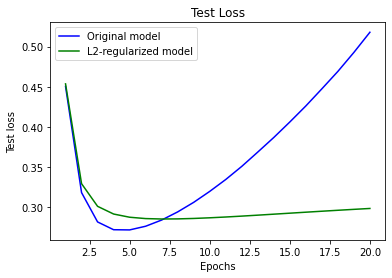

In [ ]:
plt.plot(range(1, 21), original_hist['test_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), l2_model_hist['test_loss'], 'g-', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()
plt.title("Test Loss")

plt.show()



As you can see, the model with L2 regularization has become much more resistant to overfitting than the reference model, 
even though both models have the same number of parameters.

## Adding dropout


Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his 
students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of 
output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a 
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 
1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test 
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to 
balance for the fact that more units are active than at training time.


This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among 
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked 
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation 
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each 
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what 
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [ ]:
# simple_model
class dropout_model(nn.Module):
    def __init__(self, hidden_units, dropout_ratio = 0.5):
        # initialize parent class
        super(dropout_model, self).__init__()
        # define layers
        self.classifier = nn.Sequential(  # define a subcomponent of neural network or another to define model
            nn.Linear(in_features=10000, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=hidden_units, out_features=1)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [ ]:
model_visual = dropout_model(16)
summary(model_visual, (10, 10_000))

Layer (type:depth-idx)                   Output Shape              Param #
dropout_model                            --                        --
├─Sequential: 1-1                        [10, 1]                   --
│    └─Linear: 2-1                       [10, 16]                  160,016
│    └─ReLU: 2-2                         [10, 16]                  --
│    └─Dropout: 2-3                      [10, 16]                  --
│    └─Linear: 2-4                       [10, 16]                  272
│    └─ReLU: 2-5                         [10, 16]                  --
│    └─Dropout: 2-6                      [10, 16]                  --
│    └─Linear: 2-7                       [10, 1]                   17
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
Total mult-adds (M): 1.60
Input size (MB): 0.40
Forward/backward pass size (MB): 0.00
Params size (MB): 0.64
Estimated Total Size (MB): 1.04

In [ ]:
original2 = simple_model(16)
original2_hist = train_model(original2, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.55209 train_acc:0.75887, valid loss:0.42885 valid acc:0.86753
Epoch:2 / 20, train loss:0.33339 train_acc:0.89162, valid loss:0.31172 valid acc:0.88571
Epoch:3 / 20, train loss:0.24910 train_acc:0.91025, valid loss:0.28006 valid acc:0.89023
Epoch:4 / 20, train loss:0.21121 train_acc:0.92387, valid loss:0.27232 valid acc:0.89222
Epoch:5 / 20, train loss:0.18720 train_acc:0.93242, valid loss:0.27351 valid acc:0.89070
Epoch:6 / 20, train loss:0.16924 train_acc:0.93974, valid loss:0.27931 valid acc:0.88939
Epoch:7 / 20, train loss:0.15477 train_acc:0.94525, valid loss:0.28797 valid acc:0.88699
Epoch:8 / 20, train loss:0.14261 train_acc:0.95057, valid loss:0.29870 valid acc:0.88431
Epoch:9 / 20, train loss:0.13211 train_acc:0.95460, valid loss:0.31103 valid acc:0.88143
Epoch:10 / 20, train loss:0.12288 train_acc:0.95840, valid loss:0.32466 valid acc:0.87892
Epoch:11 / 20, train loss:0.11466 train_acc:0.96196, valid loss:0.33938 valid acc:0.87656
Epoc

In [ ]:
dropout = dropout_model(16, 0.5)
dropout_hist = train_model(dropout, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.65666 train_acc:0.64806, valid loss:0.59279 valid acc:0.84735
Epoch:2 / 20, train loss:0.54477 train_acc:0.78389, valid loss:0.44914 valid acc:0.86901
Epoch:3 / 20, train loss:0.43545 train_acc:0.84047, valid loss:0.35407 valid acc:0.88111
Epoch:4 / 20, train loss:0.36370 train_acc:0.87164, valid loss:0.30834 valid acc:0.88647
Epoch:5 / 20, train loss:0.32143 train_acc:0.88831, valid loss:0.28532 valid acc:0.88967
Epoch:6 / 20, train loss:0.28770 train_acc:0.90205, valid loss:0.27457 valid acc:0.89190
Epoch:7 / 20, train loss:0.26705 train_acc:0.91121, valid loss:0.27117 valid acc:0.89158
Epoch:8 / 20, train loss:0.24619 train_acc:0.91908, valid loss:0.27182 valid acc:0.89174
Epoch:9 / 20, train loss:0.22805 train_acc:0.92615, valid loss:0.27535 valid acc:0.89178
Epoch:10 / 20, train loss:0.21847 train_acc:0.92847, valid loss:0.28050 valid acc:0.89031
Epoch:11 / 20, train loss:0.20595 train_acc:0.93338, valid loss:0.28740 valid acc:0.89078
Epoc

Let's plot the results:

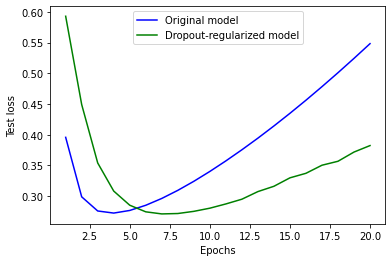

In [ ]:
plt.plot(range(1, 21), original2_hist['test_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), dropout_hist['test_loss'], 'g-', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()

plt.show()

## Batch Normalization

In [ ]:
# simple_model
class batchnorm_model(nn.Module):
    def __init__(self, hidden_units, dropout_ratio = 0.5):
        # initialize parent class
        super(batchnorm_model, self).__init__()
        # define layers
        self.classifier = nn.Sequential(  # define a subcomponent of neural network or another to define model
            # nn.Dropout(dropout_ratio),
            nn.Linear(in_features=10000, out_features=hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),
            # nn.BatchNorm1d(hidden_units),
            nn.Linear(in_features=hidden_units, out_features=1)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [ ]:
model_visual = batchnorm_model(16, dropout_ratio = 0.5)
summary(model_visual, (10, 10_000))

Layer (type:depth-idx)                   Output Shape              Param #
batchnorm_model                          --                        --
├─Sequential: 1-1                        [10, 1]                   --
│    └─Linear: 2-1                       [10, 16]                  160,016
│    └─ReLU: 2-2                         [10, 16]                  --
│    └─BatchNorm1d: 2-3                  [10, 16]                  32
│    └─Linear: 2-4                       [10, 16]                  272
│    └─ReLU: 2-5                         [10, 16]                  --
│    └─Dropout: 2-6                      [10, 16]                  --
│    └─Linear: 2-7                       [10, 1]                   17
Total params: 160,337
Trainable params: 160,337
Non-trainable params: 0
Total mult-adds (M): 1.60
Input size (MB): 0.40
Forward/backward pass size (MB): 0.00
Params size (MB): 0.64
Estimated Total Size (MB): 1.05

In [ ]:
batch = batchnorm_model(16, dropout_ratio = 0.5)
batch_hist = train_model(batch, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.52756 train_acc:0.77933, valid loss:0.36782 valid acc:0.87976
Epoch:2 / 20, train loss:0.30830 train_acc:0.89338, valid loss:0.28028 valid acc:0.88691
Epoch:3 / 20, train loss:0.21474 train_acc:0.92591, valid loss:0.29147 valid acc:0.88055
Epoch:4 / 20, train loss:0.16136 train_acc:0.94949, valid loss:0.32870 valid acc:0.87328
Epoch:5 / 20, train loss:0.11334 train_acc:0.96499, valid loss:0.38387 valid acc:0.86629
Epoch:6 / 20, train loss:0.08066 train_acc:0.97762, valid loss:0.44552 valid acc:0.86141
Epoch:7 / 20, train loss:0.05277 train_acc:0.98717, valid loss:0.52628 valid acc:0.85706
Epoch:8 / 20, train loss:0.03371 train_acc:0.99241, valid loss:0.59930 valid acc:0.85522
Epoch:9 / 20, train loss:0.02319 train_acc:0.99500, valid loss:0.68712 valid acc:0.85370
Epoch:10 / 20, train loss:0.01736 train_acc:0.99540, valid loss:0.74264 valid acc:0.85274
Epoch:11 / 20, train loss:0.01443 train_acc:0.99652, valid loss:0.79528 valid acc:0.85250
Epoc

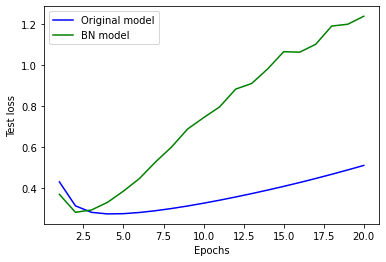

In [ ]:
plt.plot(range(1, 21), original2_hist['test_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), batch_hist['test_loss'], 'g-', label='BN model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()

plt.show()

The effect of batch normalization is not very significant in this case. However, it is considered as a useful technique used in training very deep neural network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.